In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor, XGBClassifier
import doubleml as dml
import matplotlib.pyplot as plt

## 1 - Preparando a base

In [2]:
import numpy as np
import pandas as pd

# 1. reprodutibilidade
np.random.seed(422)

# 2. tamanho da amostra e número de clusters
n = 10_000
n_clust = 5

# 3. atribuição a clusters + interceptos aleatórios
cluster_id = np.random.choice(range(n_clust), size=n)
cluster_effect = np.random.normal(loc=0, scale=1.0, size=n_clust)

# 4. covariáveis
X1 = np.random.normal(loc=0, scale=1, size=n)         # gaussiana
X2 = np.random.normal(loc=5, scale=2, size=n)         # gaussiana
X4 = np.random.exponential(scale=1, size=n)           # assimétrica
X5 = np.random.poisson(lam=3, size=n)                 # contagem
X6 = np.random.choice(['C1','C2','C3'],                # categórica 3 níveis
                      size=n, p=[0.5,0.3,0.2])
X6_num = pd.get_dummies(X6).values @ np.array([0, 0.5, -0.5])

# 5. um confundidor não observado
U = np.random.normal(0, 1, size=n)

# 6. propensão com interações (tratamento sera desbalanceado pelas variaveis X1, X2 e X6)
logit = (
    0.2 * X1 
  - 0.15 * X2 
  + 1.2  * X6_num 
  + 0.8  * X1 * X6_num   # interação
  + 0.2  * U             # confundidor não observado
)
propensity = 1 / (1 + np.exp(-logit))
T = np.random.binomial(1, propensity)

# 7. efeito de tratamento heterogêneo (depende de X4 e X6)
TE = 2.0 + 1.0 * np.sqrt(X4 + 1) - 0.5 * (X6 == 'C3')

# 8. ruído heterocedástico
noise_sd = 1 + 0.5 * np.abs(X4)
noise    = np.random.normal(loc=0, scale=noise_sd, size=n)

# 9. Variavel objetivo Y
Y = (
    5
  + TE * T
  + 1.2 * (X1**2)
  - 1.5 * np.log(np.abs(X2) + 1)
  + 0.8 * X5
  + 0.4 * X4
  + 0.7 * X6_num
  + cluster_effect[cluster_id]
  + noise
)

# 10. montagem do DataFrame
df = pd.DataFrame({
    'Y':          Y,
    'T':          T,
    'X1':         X1,
    'X2':         X2,
    'X4':         X4,
    'X5':         X5,
    'X6':         X6,
    'cluster_id': cluster_id
})

In [3]:
# Verdadeiro Efeito Médio do Tratamento (ATE)
TE.mean()

3.2768279548662047

In [4]:
df.head()

,Y,T,X1,X2,X4,X5,X6,cluster_id
0,10.441602,0,-1.265842,4.092662,0.189403,5,C2,2
1,8.894606,1,-0.558146,5.514226,0.783577,5,C1,2
2,7.351063,0,1.697067,3.926277,0.169392,1,C3,0
3,10.362764,1,0.473085,9.349065,2.130764,3,C2,0
4,8.861628,1,0.527927,2.994966,0.737608,2,C2,4


In [5]:
# Transformando a variavel qualitativa via dummie (assumindo B como referencia)
dummies = pd.get_dummies(df['X6'], prefix='X6', drop_first=True, dtype=float)

# Inserindo a nova variavel no data frame original
df = pd.concat([df, dummies], axis=1)

In [6]:
df.head()

,Y,T,X1,X2,X4,X5,X6,cluster_id,X6_C2,X6_C3
0,10.441602,0,-1.265842,4.092662,0.189403,5,C2,2,1.0,0.0
1,8.894606,1,-0.558146,5.514226,0.783577,5,C1,2,0.0,0.0
2,7.351063,0,1.697067,3.926277,0.169392,1,C3,0,0.0,1.0
3,10.362764,1,0.473085,9.349065,2.130764,3,C2,0,1.0,0.0
4,8.861628,1,0.527927,2.994966,0.737608,2,C2,4,1.0,0.0


In [7]:
# Nome das variaveis que serao as confundidoras do modelo
features_base = ['X1','X2','X4','X5','X6_C2','X6_C3']

## 2 - Verificando o pressuposto da positividade

In [8]:
# Para evitar o overfitting no calculo do propensity score, vamos separar a base em duas, assim, treinaremos dois modelos
np.random.seed(42)
df1 = df.sample(frac = 0.5)
df2 = df.drop(df1.index)

In [9]:
from sklearn.linear_model import LogisticRegression
# Vamos fazer duas regressoes logisticas para estimar os propensity scores, cada uma vai ser treinada em metade da base
logit1 = LogisticRegression()
logit2 = LogisticRegression()

# Treinando os modelos em cada parte da base, prevendo T com base nas variaveis confundidoras (X)
logit1.fit(df1[['X1','X2','X4','X5','X6_C2','X6_C3']], df1['T'])
logit2.fit(df2[['X1','X2','X4','X5','X6_C2','X6_C3']], df2['T'])


# O modelo treinado na base 1 vai ser usado para calcular o score na base 2
# O modelo treinado na base 2 vai ser usado para calcular o score na base 1
df1['propensity_score'] = logit2.predict_proba(df1[['X1','X2','X4','X5','X6_C2','X6_C3']])[:, 1]
df2['propensity_score'] = logit1.predict_proba(df2[['X1','X2','X4','X5','X6_C2','X6_C3']])[:, 1]

# juntando as bases novamente
df_f = pd.concat([df1,df2])

In [10]:
df_f.head()

,Y,T,X1,X2,X4,X5,X6,cluster_id,X6_C2,X6_C3,propensity_score
6252,10.526104,1,0.314130,9.345531,0.548184,5,C1,0,0.0,0.0,0.222550
4684,6.262451,0,1.166495,5.933869,0.743831,3,C1,0,0.0,0.0,0.353902
1731,5.873716,1,0.083750,4.612645,0.195561,0,C1,1,0.0,0.0,0.326049
4742,13.623841,1,-1.611314,0.779926,0.998823,1,C1,2,0.0,0.0,0.361966
4521,9.555984,0,-1.342107,3.989819,1.187833,4,C1,3,0.0,0.0,0.288668


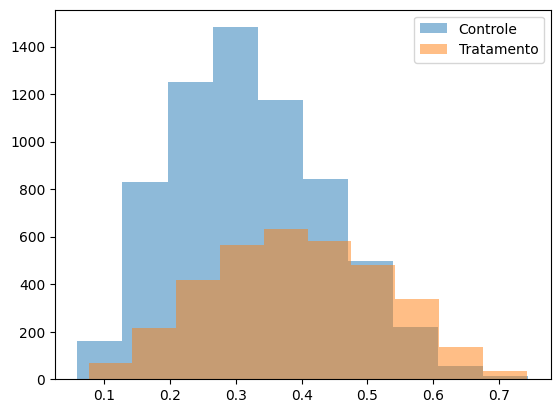

In [11]:
import matplotlib.pyplot as plt
# Visualizando se temos unidades de controle e tratamento nas mesmas faixas do propensity score (Pressuposto da Positividade)
plt.hist(df_f[df_f['T'] == 0]['propensity_score'], label = 'Controle', alpha = 0.5)
plt.hist(df_f[df_f['T'] == 1]['propensity_score'], label = 'Tratamento', alpha = 0.5)
plt.legend()
plt.show()

## 3 - Verificando equilibrio entre as variaveis X dos grupos controle e tratamento (SMD)

In [12]:
# Função para SMD contínuas
def compute_smd_continuous(x, t):
    treated = x[t == 1]
    control = x[t == 0]
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((np.var(treated, ddof=1) + np.var(control, ddof=1)) / 2)
    return mean_diff / pooled_std

# Função para SMD categóricas
def compute_smd_categorical(x, t):
    treated = pd.crosstab(index=t, columns=x, normalize='index').loc[1]
    control = pd.crosstab(index=t, columns=x, normalize='index').loc[0]
    smd = np.sum(np.abs(treated - control)) / 2
    return smd

# Identificando variáveis contínuas e categóricas
continuous_vars = ['X1','X2','X4','X5']
categorical_vars = ['X6']

# Calculando SMDs
smd_results = {}

for col in continuous_vars:
    smd = compute_smd_continuous(df[col], df['T'])
    smd_results[col] = smd

for col in categorical_vars:
    smd = compute_smd_categorical(df[col], df['T'])
    smd_results[col] = smd

# Criar DataFrame de SMDs
smd_df = pd.DataFrame.from_dict(smd_results, orient='index', columns=['SMD'])
smd_df = smd_df.sort_values(by='SMD', ascending=False)

print("📋 Relatório de Balanceamento:")
print(smd_df)

# Relatorio revela que os grupos tratamento e controle sao desbalanceados pelas variaveis X1, X2 e X6

📋 Relatório de Balanceamento:
         SMD
X1  0.235490
X6  0.170714
X4  0.032110
X5  0.020512
X2 -0.264729


## 4 - Verificando o resultado de uma regressao linear Y ~ T

In [13]:
import statsmodels.api as sm

In [15]:
X = df[['T']]
y = df[['Y']]
# Adicionar constante
X_const = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X_const)
results = model.fit()

# Exibir o resumo completo
print(results.summary())

#O impacto de T [3.52;3.7] não contem o valor especificado na funcao geradora dos dados (ATE = 3.27)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     3734.
Date:                Sat, 03 May 2025   Prob (F-statistic):               0.00
Time:                        01:24:16   Log-Likelihood:                -24615.
No. Observations:               10000   AIC:                         4.923e+04
Df Residuals:                    9998   BIC:                         4.925e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6430      0.035    189.183      0.0

## 5 - Ajustando os modelos do DoubleML

In [16]:
# Ajustando os modelos de XGBoost que serão usados

# Modelo que preve o Outcome (Y) com base nas confundidoras (X)
boost = XGBRegressor(n_jobs=1, objective = "reg:squarederror")

# Modelo que preve o Tratamento (T) com base nas confundidoras (X)
boost_class = XGBClassifier(n_jobs=1,
                            objective = "binary:logistic", eval_metric = "logloss")

In [17]:
# Inicializando o DoubleML
data_dml_base = dml.DoubleMLData(df,
                                 y_col='Y',
                                 d_cols='T',
                                 x_cols=features_base)

In [18]:
np.random.seed(42)
# Ajustando o DoubleML, definindo o numero de folds para o cross-fiting (n_folds) e número de repeticoes do processo (n_rep)
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 10,
                                n_rep = 5)

In [19]:
# Hiperparametros que serao tunados de cada modelo de XGBoost (Y~X e T~X)
par_grids = {'ml_l': {'learning_rate': [0.01, 0.05, 0.1, 0.2,0.5,1],
    'n_estimators': [100, 200, 300,500,900,1200],
    'max_depth': [3, 4, 5, 6,8,10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3,0.5,1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1,0.3,0.5,0.8, 1,10],
    'reg_lambda': [0, 0.1,0.3,0.5,0.8, 1,10]},
             'ml_m': {'learning_rate': [0.01, 0.05, 0.1, 0.2,0.5,1],
    'n_estimators': [100, 200, 300,500,900,1200],
    'max_depth': [3, 4, 5, 6,8,10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3,0.5,1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1,0.3,0.5,0.8, 1,10],
    'reg_lambda': [0, 0.1,0.3,0.5,0.8, 1,10]}}

In [20]:
dml_plr_boost.tune(
    par_grids,
    search_mode='randomized_search',
    set_as_params = True,
    n_iter_randomized_search=50,
    return_tune_res=True
)
# Abaixo esta disposto o melhor conjunto de hiperparametros para cada modelo

[{'params': {'ml_l': [{'subsample': 0.7,
     'reg_lambda': 10,
     'reg_alpha': 0.3,
     'n_estimators': 1200,
     'min_child_weight': 3,
     'max_depth': 3,
     'learning_rate': 0.01,
     'gamma': 0.5,
     'colsample_bytree': 0.9}],
   'ml_m': [{'subsample': 1.0,
     'reg_lambda': 0.1,
     'reg_alpha': 1,
     'n_estimators': 100,
     'min_child_weight': 1,
     'max_depth': 3,
     'learning_rate': 0.05,
     'gamma': 0,
     'colsample_bytree': 0.9}]},
  'tune_res': {'l_tune': [RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                       estimator=XGBRegressor(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, device=None,
                                              early_stopping_rounds=N

## 6 - Executando o DoubleML

In [21]:
# Rodando o modelo DoubleML utilizando os melhores hiperparametros encontrados
dml_plr_boost.fit(store_predictions=True)

# Mostrando o impacto de T em Y e seus respectivos intervalos de confianca (com Bootstrap ao final)
print(dml_plr_boost.summary)
print(dml_plr_boost)
bootstrap_results = dml_plr_boost.bootstrap(method='normal', n_rep_boot=100) # intervalo de confianca com Bootstrap
print("Bootstrap confidence intervals:\n", bootstrap_results.confint(joint=True))
# Valor do ATE ficou proximo do verdadeiro (3.27)

       coef   std err          t  P>|t|     2.5 %    97.5 %
T  3.284566  0.037845  86.789512    0.0  3.210444  3.358687
================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['T']
Covariates: ['X1', 'X2', 'X4', 'X5', 'X6_C2', 'X6_C3']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None

# 7 - Estudando o efeito heterogêneo do tratamento por grupos (GATE)

In [22]:
# O metodo de calculo do efeito do tratamento por grupo de observacoes so é viavel com o parametro de n_rep do cross-fitting = 1, por isso, vamos reajustar o modelo
dml_plr_boost = dml.DoubleMLPLR(data_dml_base,
                                ml_l = boost,
                                ml_m = boost_class,
                                n_folds = 10,
                                n_rep = 1)

dml_plr_boost.tune(
    par_grids,
    search_mode='randomized_search',
    set_as_params = True,
    n_iter_randomized_search=50,
    return_tune_res=True
)

dml_plr_boost.fit(store_predictions=True)

In [23]:
# Construindo grupos de observacoes que quero identificar diferenca no tratamento
# Faremos pela variavel X6 que esta na formula do efeito do tratamento
groups = pd.DataFrame(df['X6'], columns=['X6'], dtype=str)

In [24]:
gate = dml_plr_boost.gate(groups=groups)
ci = gate.confint(level=0.95, joint=True, n_rep_boot=100) # com bootstrapping
print(ci)
# O grupo C3 tem efeito estatisticamente diferente dos demais

             2.5 %    effect    97.5 %
Group_C1  3.155295  3.329594  3.503892
Group_C2  3.178694  3.392042  3.605390
Group_C3  2.527592  2.850850  3.174108


In [25]:
# Outro grupo relevante, categorizando a variavel X4
groups2 = pd.DataFrame(pd.qcut(df['X4'],q=8), columns=['X4'], dtype=str)

In [26]:
groups2.value_counts()

X4                             
(-0.0009660000000000001, 0.134]    1250
(0.134, 0.285]                     1250
(0.285, 0.474]                     1250
(0.474, 0.699]                     1250
(0.699, 0.985]                     1250
(0.985, 1.396]                     1250
(1.396, 2.092]                     1250
(2.092, 8.18]                      1250
Name: count, dtype: int64

In [27]:
gate = dml_plr_boost.gate(groups=groups2)
ci = gate.confint(level=0.95, joint=True, n_rep_boot=100) # com bootstrapping
print(ci)
# Conforme aumenta o valor da variavel, maior o efeito do tratamento

                                          2.5 %    effect    97.5 %
Group_(-0.0009660000000000001, 0.134]  2.597660  2.857556  3.117451
Group_(0.134, 0.285]                   2.782204  3.059438  3.336672
Group_(0.285, 0.474]                   2.796153  3.100805  3.405457
Group_(0.474, 0.699]                   2.768994  3.063404  3.357814
Group_(0.699, 0.985]                   2.957340  3.303278  3.649216
Group_(0.985, 1.396]                   2.794802  3.163357  3.531912
Group_(1.396, 2.092]                   3.336831  3.755128  4.173425
Group_(2.092, 8.18]                    3.297411  3.890562  4.483714
